In [1]:
import easyocr
reader = easyocr.Reader(['en'])
image_path = r'C:\Mine\college\Vs\Medical Extractor\Images\2.jpeg'  
results = reader.readtext(image_path)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
for detection in results:
    print(detection[1]) 

Ultrasonography Report
MR SAMEH MOHAMED EL-SAYED ATTEYA
DEAR SIR
03/06/2007
ABDOMINAL SONOGRAPHY_REVEALED
The liver is of normal size and homogenous echogenicity with no focal lesions detected.
No intra or extra
hepatic biliary radicles dilatation.
The
bladder shows normal wall thickness with no stones inside.
Normal caliber of the portal vein and CBD.
Normal sonographic appearance of the pancreas.
The spleen is of normal size with homogenous echogenicity.
Both kidneys are normal in site, size, shape, parenchymal thickness and echogenicity
with no renal stones or back pressure obstructive changes.
Right kidney measures
10.5 X
3.8 cm with 14 mm parenchymal thickness.
Left kidney measures
9. x
4.4 cm with 15 mm parenchymal thickness.
No para-aortic lymphadenopathy:
No ascites.
OPINION  :
Normal abdominal ultrasonography.
MUCH OBLIGED
DR OSAMA ABOU EL-NAGA
NM
gall


In [2]:
extracted_text = " ".join([detection[1] for detection in results])
print("Extracted Text as a Paragraph:\n")
print(extracted_text)

Extracted Text as a Paragraph:

Ultrasonography Report MR SAMEH MOHAMED EL-SAYED ATTEYA DEAR SIR 03/06/2007 ABDOMINAL SONOGRAPHY_REVEALED The liver is of normal size and homogenous echogenicity with no focal lesions detected. No intra or extra hepatic biliary radicles dilatation. The bladder shows normal wall thickness with no stones inside. Normal caliber of the portal vein and CBD. Normal sonographic appearance of the pancreas. The spleen is of normal size with homogenous echogenicity. Both kidneys are normal in site, size, shape, parenchymal thickness and echogenicity with no renal stones or back pressure obstructive changes. Right kidney measures 10.5 X 3.8 cm with 14 mm parenchymal thickness. Left kidney measures 9. x 4.4 cm with 15 mm parenchymal thickness. No para-aortic lymphadenopathy: No ascites. OPINION  : Normal abdominal ultrasonography. MUCH OBLIGED DR OSAMA ABOU EL-NAGA NM gall


Annotated image saved at C:\Mine\college\Vs\Medical Extractor\Images\2_annotated.jpeg


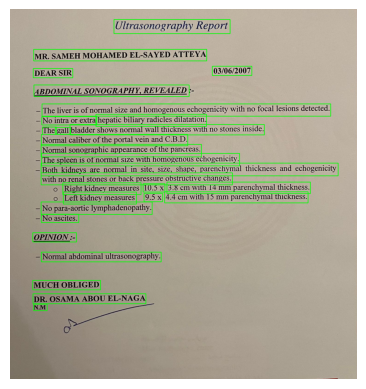

In [13]:
import cv2
from matplotlib import pyplot as plt

image = cv2.imread(image_path)
annotated_image = image.copy()

# bbox
for (bbox, text, prob) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    cv2.rectangle(annotated_image, top_left, bottom_right, (0, 255, 0), 2)

# Save the annotated copy to a new file
output_path = image_path.replace(".jpeg", "_annotated.jpeg")
cv2.imwrite(output_path, annotated_image)
print(f"Annotated image saved at {output_path}")

# display
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [8]:
import subprocess
import json
import requests


GROQ_API_KEY = "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"
GROQ_API_URL = "https://api.groq.com/openai/v1/chat/completions"

def query_groq_llama(prompt):
    """Sends a prompt to the DeepSeek model on Groq and returns the response."""
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "deepseek-r1-distill-qwen-32b",  # ✅ Confirmed working DeepSeek model on Groq
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.7,
        "max_tokens": 500
    }

    response = requests.post(GROQ_API_URL, headers=headers, json=payload)
    
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"].strip()
    else:
        print("Groq API Error:", response.status_code, response.text)
        return None


def perform_llm(extracted_text):
    """Prepares the prompt and retrieves structured output from the LLaMA model."""
    prompt = f"""
You are an advanced medical assistant. Validate and transform the following unstructured medical text into a structured JSON format with these sections:
1. Patient Information
2. Date of Issue
3. Type of Report (Heart, Brain, Skin, Bones, etc.)
4. Medical Problem (technical terms for doctors)
5. Simplified Explanation of the Medical Problem (for non-experts)

Unstructured Medical Text:
{extracted_text}

Output only the following JSON:
{{
    "Patient Information": "string",
    "Date of Issue": "string",
    "Type of Report": "string",
    "Medical Problem": "string",
    "Simplified Explanation": "string"
}}
"""
    return query_groq_llama(prompt)

In [9]:
data = perform_llm(extracted_text)

In [10]:
print(data)

<think>
Alright, so I need to help the user by transforming an unstructured medical text into a structured JSON format. Let me start by carefully reading the query and the provided medical text.

First, the user is asking for an advanced medical assistant to validate and transform the given text. The JSON should include sections like Patient Information, Date of Issue, Type of Report, Medical Problem, and Simplified Explanation. 

Looking at the medical text, I see it's an Ultrasonography Report. The patient's name is MR SAMEH MOHAMED EL-SAYED ATTEYA. The date is 03/06/2007. The type of report is Abdominal Sonography. The findings mention that all organs like liver, bladder, pancreas, spleen, and kidneys appear normal. The opinion is "Normal abdominal ultrasonography."

So, I need to extract each piece of information. The patient's name is straightforward. The date is clearly stated. The type of report is Abdominal Sonography. For the Medical Problem, since all findings are normal, it 

In [15]:
import re
def extract_json(response):
    """Extracts JSON part from the response."""
    # Regular expression to match valid JSON block
    json_match = re.search(r'\{.*\}', response, re.DOTALL)
    
    if json_match:
        try:
            # Parse the matched JSON string
            structured_output = json.loads(json_match.group(0))
            return structured_output
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            return None
    else:
        print("No valid JSON found in the response.")
        return None

In [16]:
final_data = extract_json(data)

In [17]:
print(final_data)

{'Patient Information': 'MR SAMEH MOHAMED EL-SAYED ATTEYA', 'Date of Issue': '03/06/2007', 'Type of Report': 'Abdominal Sonography', 'Medical Problem': 'No abnormalities detected. Normal abdominal ultrasonography findings.', 'Simplified Explanation': 'The ultrasound scan of the abdomen showed no issues. All organs, including the liver, bladder, pancreas, spleen, and kidneys, appeared normal. No signs of disease or abnormalities were found.'}


## Formatting Agent

In [ ]:
!pip install LiteLLM

In [1]:
!pip install crewai

  Obtaining dependency information for crewai from https://files.pythonhosted.org/packages/80/a9/18597cd8075124f1e903e5c6070c6397477d25e88f787014c712cd3e1c45/crewai-0.114.0-py3-none-any.whl.metadata
  Using cached crewai-0.114.0-py3-none-any.whl.metadata (33 kB)
  Obtaining dependency information for appdirs>=1.4.4 from https://files.pythonhosted.org/packages/3b/00/2344469e2084fb287c2e0b57b72910309874c3245463acd6cf5e3db69324/appdirs-1.4.4-py2.py3-none-any.whl.metadata
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Obtaining dependency information for auth0-python>=4.7.1 from https://files.pythonhosted.org/packages/ac/d1/800ab8dfe15f00836b8d1ea41f68f5e4731a96e8fc19548993996f3b5728/auth0_python-4.9.0-py3-none-any.whl.metadata
  Using cached auth0_python-4.9.0-py3-none-any.whl.metadata (9.0 kB)
  Obtaining dependency information for chromadb>=0.5.23 from https://files.pythonhosted.org/packages/22/c8/06214f13c0e83b9ffc597496491097b176d3039609497a3654b30b2ba114/chroma


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from crewai import Agent, Task, Crew

### LLM Library

In [38]:
import requests, json
from litellm import LiteLLM
from crewai import Agent, Task, Crew

import os
os.environ["GROQ_API_KEY"] = "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"

# # Query function using LiteLLM
# def query_deepseek(prompt):
#     GROQ_API_KEY = os.getenv("GROQ_API_KEY")
#     GROQ_API_URL = "https://api.groq.com/openai/v1/chat/completions"

#     headers = {
#         "Authorization": f"Bearer {GROQ_API_KEY}",
#         "Content-Type": "application/json"
#     }

#     payload = {
#         "model": "groq/deepseek-r1-distill-qwen-32b",
#         "messages": [
#             {"role": "user", "content": prompt}
#         ],
#         "temperature": 0.7,
#         "max_tokens": 500
#     }

#     response = requests.post(GROQ_API_URL, headers=headers, json=payload)
#     if response.status_code == 200:
#         data = response.json()
#         return data['choices'][0]['message']['content'].strip()
#     else:
#         raise Exception(f"Groq API error {response.status_code}: {response.text}")


In [39]:
# class DeepseekLLM:
#     def __call__(self, prompt: str) -> str:
#         return query_deepseek(prompt)

### Formatting Agent Creation

In [40]:
# deepseek_llm = DeepseekLLM()

In [41]:
Format_Agent = Agent(
    role="Medical Document Formatter",
    goal="Structure raw OCR text from medical notes into consistent formatted data",
    backstory="""You are an expert in medical documentation with years of 
            experience organizing clinical notes. You excel at identifying key information
            in unstructured medical text and formatting it properly.""",
    allow_delegation=False,
    verbose=True,
    llm="groq/deepseek-r1-distill-qwen-32b"
)

In [42]:
extracted_text = "Ultrasonography Report MR SAMEH MOHAMED EL-SAYED ATTEYA DEAR SIR 03/06/2007 ABDOMINAL SONOGRAPHY_REVEALED The liver is of normal size and homogenous echogenicity with no focal lesions detected. No intra or extra hepatic biliary radicles dilatation. The bladder shows normal wall thickness with no stones inside. Normal caliber of the portal vein and CBD. Normal sonographic appearance of the pancreas. The spleen is of normal size with homogenous echogenicity. Both kidneys are normal in site, size, shape, parenchymal thickness and echogenicity with no renal stones or back pressure obstructive changes. Right kidney measures 10.5 X 3.8 cm with 14 mm parenchymal thickness. Left kidney measures 9. x 4.4 cm with 15 mm parenchymal thickness. No para-aortic lymphadenopathy: No ascites. OPINION  : Normal abdominal ultrasonography. MUCH OBLIGED DR OSAMA ABOU EL-NAGA NM gall"

In [43]:
Format_task = Task(
    description=f"""
           You are an advanced medical assistant. Validate and transform the following unstructured medical text into a structured JSON format with these sections:
            1. Patient Information
            2. Date of Issue
            3. Type of Report (Heart, Brain, Skin, Bones, etc.)
            4. Medical Problem (technical terms for doctors)
            5. Simplified Explanation of the Medical Problem (for non-experts)

            Unstructured Medical Text:
            {extracted_text}

            Output only the following JSON:
            {{
                "Patient Information": "string",
                "Date of Issue": "string",
                "Type of Report": "string",
                "Medical Problem": "string",
                "Simplified Explanation": "string"
            }}
            """,
    agent=Format_Agent,
    expected_output="A JSON object containing the structured medical information with the five required fields."
)

In [44]:
crew = Crew(
    agents=[Format_Agent],
    tasks=[Format_task],
    verbose=True
)

In [45]:
result = crew.kickoff()
print(result)

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 5e462fa4-f1da-4957-a90e-2c3ad48721d6                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: 15b831ae-8d67-44fd-b53d-c7e38db6b6fe
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: 15b831ae-8d67-44fd-b53d-c7e38db6b6fe
       Status: Executing Task...
    └── 🤖 Agent: Medical Document Formatter
            Status: In Progress

# Agent: Medical Document Formatter
## Task: 
           You are an advanced medical assistant. Validate and transform the following unstructured medical text into a structured JSON format with these sections:
            1. Patient Information
            2. Date of Issue
            3. Type of Report (Heart, Brain, Skin, Bones, etc.)
            4. Medical Problem (technical terms for doctors)
            5. Simplified Explanation of the Medical Problem (for non-experts)

            Unstructured Medical Text:
            Ultrasonography Report MR SAMEH MOHAMED EL-SAYED ATTEYA DEAR SIR 03/06/2007 ABDOMINAL SONOGRAPHY_REVEALED The liver is of normal size and homogenous echogenicity with no focal lesions detected. No intra or extra hepatic biliary radicles dilatation. The bladder shows normal wall thickness with no stones inside. Normal caliber of the portal vein and CBD. Normal sonographic appearance of the pancreas. The spleen is of normal size with homogenous echogenicity. Both kidn

🚀 Crew: crew
└── 📋 Task: 15b831ae-8d67-44fd-b53d-c7e38db6b6fe
       Status: Executing Task...
    └── 🤖 Agent: Medical Document Formatter
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: 15b831ae-8d67-44fd-b53d-c7e38db6b6fe
       Assigned to: Medical Document Formatter
       Status: ✅ Completed
    └── 🤖 Agent: Medical Document Formatter
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 15b831ae-8d67-44fd-b53d-c7e38db6b6fe                                                                     │
│  Agent: Medical Document Formatter                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 5e462fa4-f1da-4957-a90e-2c3ad48721d6                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

<think>
Okay, I need to structure this medical report into a JSON format as specified. Let me start by reading through the unstructured text carefully.

First, I'll identify the patient's name. It's listed as "MR SAMEH MOHAMED EL-SAYED ATTEYA". That should go under "Patient Information".

Next, the date of issue is "03/06/2007". That's straightforward for the "Date of Issue" field.

The type of report is mentioned as "Ultrasonography Report". So, "Type of Report" will be "Ultrasonography".

Looking at the medical findings, the report states that the abdominal sonography revealed everything normal. The liver, bladder, portal vein, pancreas, spleen, and kidneys all appear normal with no abnormalities detected. The opinion is "Normal abdominal ultrasonography". Therefore, "Medical Problem" should be "Normal abdominal ultrasonography" since there are no issues found.

For the "Simplified Explanation", I need to translate the medical terms into layman's language. So, it would be something l